# Characteristics of U.S. Cities and Capitals

# Data and Setup
For this project, our primary dataset will be a dataframe that contains **19095 cities** in the U.S. with a list of variables that characterize certain features for each city. These variables/features include:

* City's Name
* City's State
* City's County
* Latitude Coordinate
* Longitude Coordinate
* Population
* Density
* If Incorporated (if a city is a legitimate city or township)
* If Military (if a town is technically a fort or military base)
* If Capital of State or Nation
* Timezone
* Ranking (1-3, descending in importance with unknown/unstated criteria; more on this later)
* Number of Zip Codes in City
    
Outside of this dataset, we collected satellite images of each U.S. capital from NASA's Earth API to observe changes over time. NASA pre-processes these images so effects like the time of day are minimized. The API is tricky to work with however, since it provides only so many images throughout a year, and only so many of those images contain traces of land, given that clouds tend to fill most of them.


For this project, our secondary dataset will be a dataframe that contains **51 US Capital Cities** with a list of variables that characterize certain features for each city. These variables/features include:

* City's Name
* City's State
* City's County
* Latitude Coordinate
* Longitude Coordinate
* Population
* Density
* Timezone
* Ranking (1-3, descending in importance with unknown/unstated criteria; more on this later)
* Number of Zip Codes in City
* % change average RGB values per year 
    

# Objectives

Now that we have our dataset, we would like to ask the following questions about it:

* Are there meaningful correlations between variables in the *us_cities* and *us_capitals* datasets?
    * Why or why not?
* How do these correlations change when looking at certain subsets?
* What could be the metric for the *ranking* variable?
* Through satellite image analysis, are there any meaningful correlations with the *us_capitals* set? 
    * Could someone implement a very basic model in this manner and yield accurate predictions for features of U.S. capitals? 
    * If not, what could be some causes? If so, could this method be broadened to non-capital cities?
    * If so, can it be generalized to all/more U.S. cities?

,city,state_id,state,county,lat,long,population,density,military,incorporated,capital,timezone,ranking,zips
0,New York,NY,New York,New York,40.6943,-73.9249,18713220,10715,0,1,0,New_York,1,309
1,Los Angeles,CA,California,Los Angeles,34.1139,-118.4068,12750807,3276,0,1,0,Los_Angeles,1,196
2,Chicago,IL,Illinois,Cook,41.8373,-87.6862,8604203,4574,0,1,0,Chicago,1,85
3,Miami,FL,Florida,Miami-Dade,25.7839,-80.2102,6445545,5019,0,1,0,New_York,1,30
4,Dallas,TX,Texas,Dallas,32.7936,-96.7662,5743938,1526,0,1,0,Chicago,1,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19090,Portage Creek,AK,Alaska,Dillingham,58.9051,-157.6695,3,0,0,0,0,Anchorage,3,1
19091,Gross,NE,Nebraska,Boyd,42.9461,-98.5697,2,6,0,1,0,Chicago,3,1
19092,Lotsee,OK,Oklahoma,Tulsa,36.1334,-96.2091,2,39,0,1,0,Chicago,3,1
19093,The Ranch,MN,Minnesota,Mahnomen,47.3198,-95.6952,2,2,0,1,0,Chicago,3,1


Salt Lake City, 2017 05 01:


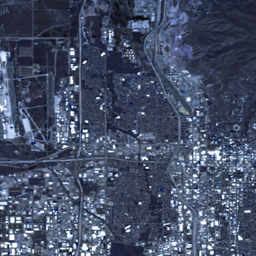

Salt Lake City, 2020 05 01:


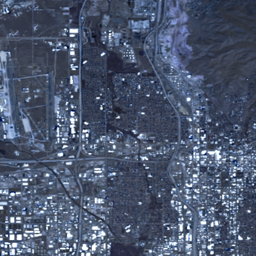

In [1]:
import os, cv2, requests, base64, imageio
from PIL import Image
from io import BytesIO
from IPython.display import display

from sklearn import tree, linear_model, metrics        # linear_model.LinearRegression() for OLS
from sklearn.metrics import homogeneity_score, v_measure_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm     # used statsmodels.formula.api.ols() for OLS
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import homogeneity_score, v_measure_score
from sklearn.preprocessing import scale

import seaborn as sn
import pandas as pd
import scipy as sc
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

us_cities = pd.read_csv("us_cities_v2.csv")
us_cities['timezone'] = [_[8:] for _ in us_cities['timezone'].values]

capitals = us_cities.loc[us_cities['capital']]
capitals = capitals.reset_index(drop=True)

for _ in ['military', 'incorporated', 'capital']:
    us_cities[_] = pd.DataFrame(1*us_cities[_])
    
incorp = us_cities.loc[us_cities['incorporated']==1]
incorp = incorp.reset_index(drop=True)

display(us_cities)

demo1 = Image.open('_DEMO_Salt_Lake_City_2017_05_01.png')
print('Salt Lake City, 2017 05 01:')
display(demo1.resize([256,256]))

demo2 = Image.open('_DEMO_Salt_Lake_City_2020_05_01.png')
print('Salt Lake City, 2020 05 01:')
display(demo2.resize([256,256]))

# Some Ethical Considerations
As you can see for the sample images queried for Salt Lake City, the latitude and longitude provided by the *us_cities* dataset return only a specific region of any given city. Our metrics for topographical changes only apply to this snapshot of a city, and can thereby miss certain regions that are expanding more rapidly than our analysis would represent; one would have to be aware of these considerations when trying to reproduce and apply our findings especially if they are to be used in supplement of other methods of determining population and other characteristics of city.

With regard to image collection through NASA's Earth API, we stayed within their 1000 image/hour query rate. To collect, filter, and requery each of our images, it took forty minutes to sample 100-700 images. The clean images are stored at a lower resolution than shown above, to reduce net file size and processing time.

**Satellite image retrieval code; it takes appoximately forty minutes to cycle through enough semi-clean images (don't worry, it can't bite now)**

In [2]:
dates = ['2016-05-01', '2019-05-01']
site = "https://api.nasa.gov/planetary/earth/imagery?"
key = "fooTh1s1saFakeKeyForDEmoPurp0s3sfoo"

def fetch_sat_imgs(dates):
    counter = 0
    for date in dates:
        for i, city in capitals.iterrows():
            date_ = date
        
            # Query API for capital image
            url = site + "lon=" + str(city['long']) + "&lat=" + str(city['lat']) + \
                      "&dim=.1&date=" + date + "&api_key=" + api_key
        
            response = requests.get(url)
            print("Ok?",response.ok,'i =',i)
            
            if response.ok:
                img = Image.open(BytesIO(response.content))
                cloudy = is_cloudy(img)
                print(cloudy)
                
                attempts = 0
                while cloudy and attempts <= 4:
                    #NOTE - Selects nearest date
                    date = next_mo(date)
                    url = site + "lon=" + str(city['long']) + "&lat=" + str(city['lat']) + \
                        "&dim=.1&date=" + date + "&api_key=" + key1
                    response = requests.get(url)
                    
                    img = Image.open(BytesIO(response.content))
                    
                    cloudy = is_cloudy(img)
                    attempts += 1
                    
                if response.ok:
                    img = img.resize((32,32))
                    
                    name = '_' + city['city'].replace(' ','_') + '_' + date.replace('-','_') + '.png'
                    #saves images to folder with noramalized name 
                    #img.save(name)
                    date = date_
                    counter += 1
                    
                if attempts > 4:
                    print(city['city'], date)
                    date = date_
                    
def next_mo(date):
    mo = '0' + str(int(date[5:7]) + 1)
    if len(mo) > 2:
        mo = mo[1:]
    date = date[:5] + mo + date[7:]
    return date

def is_cloudy(img):
    #Takes Image object, returns bool if it meets 'cloudy' criteria
    k = 75 #Threshold coeff.
    
    hist = img.histogram()
    Rm = np.mean(hist[:256])
    Gm = np.mean(hist[256:512])
    Bm = np.mean(hist[512:])
    W = [hist[255], hist[511], hist[-1]]
    
    if W[0] > k*Rm or W[1] > k*Gm or W[2] > k*Bm:
        return True
    else:
        return False

# Exploratory Analysis of Primary Data Set (All Cities) 

Description of U.S. Cities Dataset:


,lat,long,population,density,military,incorporated,capital,ranking,zips
count,19095.000000,19095.000000,1.909500e+04,19095.000000,19095.000000,19095.000000,19095.000000,19095.000000,19095.000000
mean,38.343561,-93.287520,1.956564e+04,583.061849,0.004294,0.678293,0.002671,2.928306,1.750039
std,6.322977,16.981737,2.308976e+05,882.553662,0.065392,0.467144,0.051613,0.267946,5.005778
min,17.955900,-176.629500,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,34.682900,-99.252750,4.110000e+02,124.000000,0.000000,0.000000,0.000000,3.000000,1.000000
50%,39.108300,-89.846900,1.448000e+03,326.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,41.677450,-81.196200,6.253000e+03,701.000000,0.000000,1.000000,0.000000,3.000000,2.000000
max,71.272800,173.123000,1.871322e+07,34277.000000,1.000000,1.000000,1.000000,3.000000,309.000000


Mapped Out:


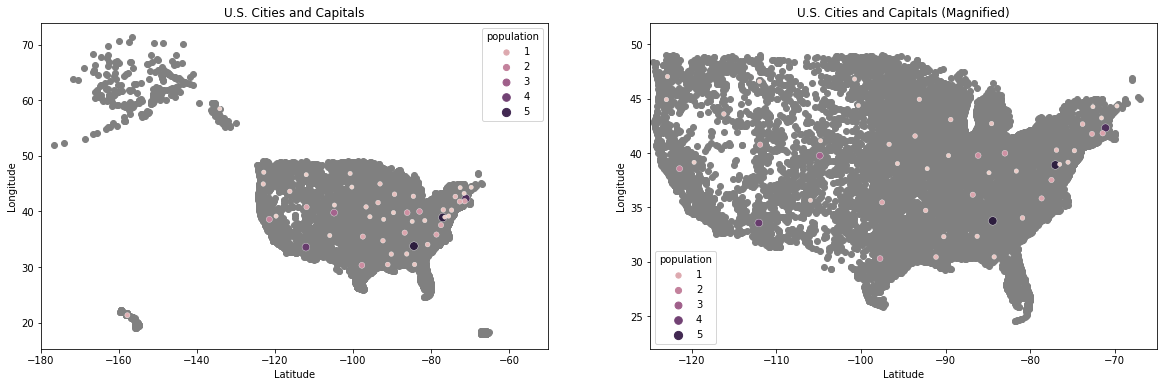

In [3]:
print('Description of U.S. Cities Dataset:')
display(us_cities.describe())

print('Mapped Out:')
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.scatter(us_cities['long'], us_cities['lat'], c='#808080')
sn.scatterplot(data=capitals, x='long', y='lat', ax=ax1, hue='population', size='population')

ax2.scatter(us_cities['long'], us_cities['lat'], c='#808080')
sn.scatterplot(data=capitals, x='long', y='lat', ax=ax2, hue='population', size='population')
#sn.color_palette("viridis", as_cmap=True)

ax1.set_xlim([-180, -50])
ax2.set_xlim([-125, -65])
ax2.set_ylim(22, 52)

ax1.set_xlabel('Latitude'); ax1.set_ylabel('Longitude');
ax2.set_xlabel('Latitude'); ax2.set_ylabel('Longitude');

ax1.title.set_text('U.S. Cities and Capitals')
ax2.title.set_text('U.S. Cities and Capitals (Magnified)')

plt.show()


**INTERPRETATION:** The description of the full dataset shows us that the minimum population of a 'city' is one person.  The mean population of a city falls somewhere above the third quartile, and 67% of our cities are incorporated.

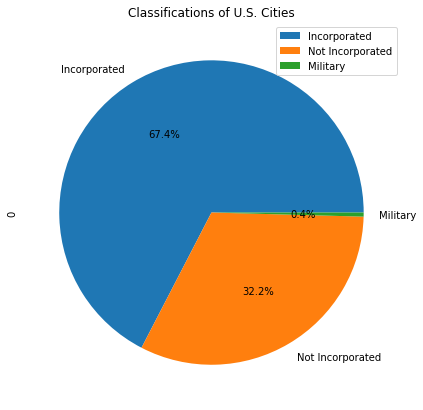

In [4]:
#All capitals and military bases are incorporated
labels = ['Incorporated', 'Not Incorporated', 'Military']
sizes = us_cities[['incorporated','military']].value_counts()
sizes = sizes.to_frame()
sizes.plot.pie(labels=labels, subplots=True, autopct='%1.1f%%', figsize=(10, 7))
_ = plt.title('Classifications of U.S. Cities')

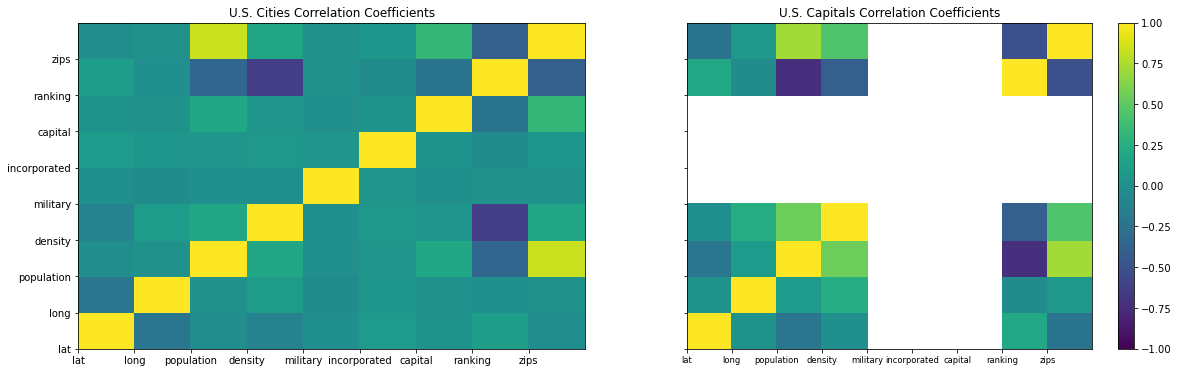

Correlation Matrix, All U.S. Cities:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,1.000000,-0.215354,-0.016597,-0.110061,-0.009581,0.092169,0.008726,0.108250,-0.030217
long,-0.215354,1.000000,0.000170,0.097152,-0.034455,0.049121,0.000463,-0.013467,0.006120
population,-0.016597,0.000170,1.000000,0.187883,-0.004031,0.044540,0.194222,-0.339824,0.840090
density,-0.110061,0.097152,0.187883,1.000000,-0.008359,0.055030,0.041689,-0.633011,0.172560
military,-0.009581,-0.034455,-0.004031,-0.008359,1.000000,0.045228,-0.003399,0.005616,0.002319
incorporated,0.092169,0.049121,0.044540,0.055030,0.045228,1.000000,0.035639,-0.036995,0.047268
capital,0.008726,0.000463,0.194222,0.041689,-0.003399,0.035639,1.000000,-0.228524,0.324285
ranking,0.108250,-0.013467,-0.339824,-0.633011,0.005616,-0.036995,-0.228524,1.000000,-0.393716
zips,-0.030217,0.006120,0.840090,0.172560,0.002319,0.047268,0.324285,-0.393716,1.000000


Correlation Matrix, All U.S. Capitals:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,1.000000,0.007915,-0.217229,-0.014718,NaN,NaN,NaN,0.201016,-0.229029
long,0.007915,1.000000,0.089589,0.238756,NaN,NaN,NaN,-0.036459,0.060839
population,-0.217229,0.089589,1.000000,0.551242,NaN,NaN,NaN,-0.721237,0.724139
density,-0.014718,0.238756,0.551242,1.000000,NaN,NaN,NaN,-0.399153,0.442941
military,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ranking,0.201016,-0.036459,-0.721237,-0.399153,NaN,NaN,NaN,1.000000,-0.509412
zips,-0.229029,0.060839,0.724139,0.442941,NaN,NaN,NaN,-0.509412,1.000000


In [5]:
corr = us_cities.corr()
c_corr = capitals.corr()
i_corr = incorp.corr()

fig2, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 6))

heatmap = ax1.pcolor(corr, vmin=-1, vmax=1)
heatmap = ax2.pcolor(c_corr, vmin=-1, vmax=1)
plt.colorbar(heatmap)

ax1.title.set_text('U.S. Cities Correlation Coefficients')
ax2.title.set_text('U.S. Capitals Correlation Coefficients')

labels=list(corr.index)
ticks = list(range(len(labels)))

_ = plt.xticks(ticks=ticks, labels=labels, size='small', stretch=150)
_ = plt.yticks(ticks=ticks, labels=labels, size='small')
plt.show()

print('Correlation Matrix, All U.S. Cities:')
display(corr)

print('Correlation Matrix, All U.S. Capitals:')
display(c_corr)

**INTERPRETATION:** From the outset, we see that the variables correlating most with *population* are (number of) *zips*, *ranking*, *capital*, and *density*. *Ranking* correlates most with *density*, *zips*, *population*, and *capital*. The correlation between population and number of ZIP codes makes sense, intuitively and seems to be a redundancy for the most part. 

The correlation matrix for the *capitals* subset, most notably, has missing rows and columns which indicates that there is no variation for those variables. In other words, all U.S. capitals are incorporated and none of them are military bases or forts (luckily this is of little surprise).

In [6]:
print("'ranking' Value Counts, for Military Bases:")
query = us_cities.loc[us_cities['military']==1]
display(pd.DataFrame(query['ranking'].value_counts()))

print("'ranking' Value Counts, for Capitals:")
display(pd.DataFrame(capitals['ranking'].value_counts()))

print("'ranking' Value Counts, for All Cities:")
display(pd.DataFrame(us_cities['ranking'].value_counts()))

query = us_cities.loc[us_cities['ranking']==1]
display(query.head(10))

'ranking' Value Counts, for Military Bases:


,ranking
3,78
2,4


'ranking' Value Counts, for Capitals:


,ranking
2,36
1,14
3,1


'ranking' Value Counts, for All Cities:


,ranking
3,17776
2,1269
1,50


,city,state_id,state,county,lat,long,population,density,military,incorporated,capital,timezone,ranking,zips
0,New York,NY,New York,New York,40.6943,-73.9249,18713220,10715,0,1,0,New_York,1,309
1,Los Angeles,CA,California,Los Angeles,34.1139,-118.4068,12750807,3276,0,1,0,Los_Angeles,1,196
2,Chicago,IL,Illinois,Cook,41.8373,-87.6862,8604203,4574,0,1,0,Chicago,1,85
3,Miami,FL,Florida,Miami-Dade,25.7839,-80.2102,6445545,5019,0,1,0,New_York,1,30
4,Dallas,TX,Texas,Dallas,32.7936,-96.7662,5743938,1526,0,1,0,Chicago,1,107
5,Philadelphia,PA,Pennsylvania,Philadelphia,40.0077,-75.1339,5649300,4554,0,1,0,New_York,1,86
6,Houston,TX,Texas,Harris,29.7863,-95.3889,5464251,1399,0,1,0,Chicago,1,181
7,Atlanta,GA,Georgia,Fulton,33.7627,-84.4224,5449398,1441,0,1,1,New_York,1,56
8,Washington,DC,District of Columbia,District of Columbia,38.9047,-77.0163,5379184,4457,0,1,1,New_York,1,292
9,Boston,MA,Massachusetts,Suffolk,42.3188,-71.0846,4688346,5532,0,1,1,New_York,1,53


**INTERPRETATION:** It appears then, that the best quantitive indicators for *ranking* are *population* and *density*. This likely shows that *ranking* prioritizes cities by historical and cultural influence, which otherwise falls outside of the scope of our datasets. Capitals tend to rank higher, it seems, because they are more likely to have higher populations, densities and some form of cultural significance--Philadelphia and Boston, for example, qualify in each of these cases.

Let's try reducing our data into a set of incorporated cities and see if a narrower set will improve correlations:

In [7]:
print('Changes in Correlation, Incorporated Cities Only:')
display(pd.DataFrame(corr - i_corr))
print('Number of cities within subset:', len(incorp), '\n')

mask = incorp['population'] > 2500
i_funnel = incorp.loc[mask]

print('Changes in Correlation, Incorporated Cities with Populations > 2500:')

display(corr - i_funnel.corr())
print('Number of cities within subset:', len(i_funnel))

Changes in Correlation, Incorporated Cities Only:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,0.000000,0.037008,0.007933,-0.063084,0.009162,NaN,0.001312,0.024813,0.014269
long,0.037008,0.000000,0.004743,0.031648,0.017560,NaN,0.002288,-0.022410,0.010798
population,0.007933,0.004743,0.000000,-0.020270,0.002029,NaN,0.001192,0.043834,-0.002556
density,-0.063084,0.031648,-0.020270,0.000000,0.004218,NaN,-0.004355,-0.040257,-0.017491
military,0.009162,0.017560,0.002029,0.004218,0.000000,NaN,0.001620,-0.002773,0.002136
incorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital,0.001312,0.002288,0.001192,-0.004355,0.001620,NaN,0.000000,0.032855,-0.000577
ranking,0.024813,-0.022410,0.043834,-0.040257,-0.002773,NaN,0.032855,0.000000,0.051527
zips,0.014269,0.010798,-0.002556,-0.017491,0.002136,NaN,-0.000577,0.051527,0.000000


Number of cities within subset: 12952 

Changes in Correlation, Incorporated Cities with Populations > 2500:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,0.000000,-0.140211,0.005135,-0.130538,-0.002660,NaN,-0.014777,0.051531,0.013632
long,-0.140211,0.000000,0.010309,0.063111,0.027374,NaN,0.005366,-0.053341,0.020722
population,0.005135,0.010309,0.000000,-0.011205,0.008260,NaN,0.007428,0.050187,-0.001901
density,-0.130538,0.063111,-0.011205,0.000000,0.018051,NaN,0.017084,-0.096039,0.006067
military,-0.002660,0.027374,0.008260,0.018051,0.000000,NaN,0.006001,-0.016465,0.010902
incorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital,-0.014777,0.005366,0.007428,0.017084,0.006001,NaN,0.000000,0.036428,0.005288
ranking,0.051531,-0.053341,0.050187,-0.096039,-0.016465,NaN,0.036428,0.000000,0.056132
zips,0.013632,0.020722,-0.001901,0.006067,0.010902,NaN,0.005288,0.056132,0.000000


Number of cities within subset: 5530


**INTERPRETATION:** The reductions in size for each dataset are relatively costly, with rather small changes in correlation. This assessment, however, excludes categorical variables such as *state*, *county*, and *timezone*.

Next up, let's see if there are any noticeable trends for the subset of military bases:

In [8]:
m_corr = us_cities.loc[us_cities['military']==1].corr()

print('Correlation Matrix, Military Bases:')
display(m_corr)

Correlation Matrix, Military Bases:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,1.000000,-0.031885,-0.136985,-0.230390,NaN,NaN,NaN,0.215967,-0.109362
long,-0.031885,1.000000,-0.010040,-0.046349,NaN,NaN,NaN,0.145512,-0.031211
population,-0.136985,-0.010040,1.000000,0.296911,NaN,NaN,NaN,-0.133724,0.149523
density,-0.230390,-0.046349,0.296911,1.000000,NaN,NaN,NaN,-0.886168,0.018367
military,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ranking,0.215967,0.145512,-0.133724,-0.886168,NaN,NaN,NaN,1.000000,0.045041
zips,-0.109362,-0.031211,0.149523,0.018367,NaN,NaN,NaN,0.045041,1.000000


**INTERPRETATION:** When it comes to military bases, the number of ZIP codes and ranking lose a fair bit of correlation with population. On the other hand, density and latitude coordinates improve, likely due to less variance.

In [9]:
capitals['timezone'].value_counts()

New_York                20
Chicago                 16
Denver                   5
Los_Angeles              4
Honolulu                 1
Juneau                   1
Phoenix                  1
Boise                    1
Indiana/Indianapolis     1
Detroit                  1
Name: timezone, dtype: int64

# Linear Regression - Populations of U.S. Cities

Now that we have identified the most important correlations in the dataset, during the explorational analysis, what combination yields the best linear regression?

In [10]:
cities_ols = sm.ols(formula="population ~ zips + capital", data=us_cities).fit() #R^2=0.713, best F-stat

# cities_ols = sm.ols(formula="population ~ zips + capital + density", data=us_cities).fit() #R^2=0.714
# cities_ols = sm.ols(formula="population ~ zips", data=us_cities).fit() #R^2=0.706

print('Population ~ zips + capital:')
display(cities_ols.summary())

Population ~ zips + capital:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 2.367e+04
Date:                Sun, 25 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:24:39   Log-Likelihood:            -2.5101e+05
No. Observations:               19095   AIC:                         5.020e+05
Df Residuals:                   19092   BIC:                         5.020e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.949e+04    950.817    -52.052      0.000   -5.14e+04   -4.76e+04
zips        4.006e+04    189.192    211.729      0.000    3.97e+04    4.04e+04
capital     -3.91e+05   1.83e+04    -21.308      0.000   -4.27e+05   -3.55e+05
==============================================================================
Omnibus:                    36940.279   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1199782700.942
Skew:                          14.076   Prob(JB):                         0.00
Kurtosis:                    1230.674   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Classification with Categorical Variables: Decision Trees

The best correlations we have for predicting a city's population are number of ZIPs, density, ranking, and if it is a capital. With a multi-linear regression, we have found a relatively effective model that relies primarily on the number of ZIPs. However, until this point, we have not explored the relationships the dataset has with respect to categorical variables *state*, *timezone*, or *county*.

Decision trees can be effective classifiers when it comes to predicting categorical variables. To use the other, string-type categorical variables, we will have to represent each string value as a unique integer. With this classification method, we want to identify which combinations of variables are best for accurately predicting (a) the state that a city is in and (b) the county a city is in for a specific state. For the second case, we will use California as the study since it should offer a larger sample size with training and testing. State and county lines have important effects on a city's population, density, and even socio-political factors that might play into *ranking*. Using classification, we can see which variables correlate with those state/county lines.

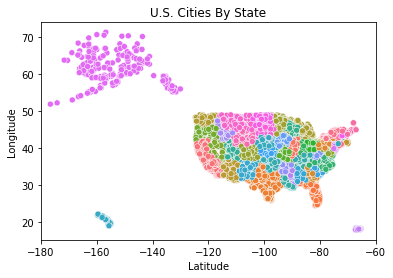

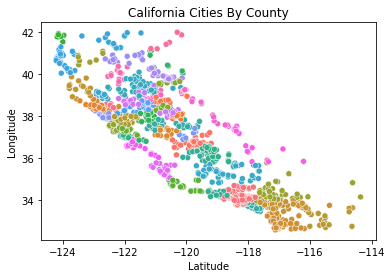

In [11]:
fig3 = sn.scatterplot(data=us_cities, x='long', y='lat', hue='state',legend=False)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
_ = plt.xlim([-180, -60])
_ = plt.title('U.S. Cities By State')
plt.show()

mask = us_cities['state_id'] == 'CA'
CA = us_cities.loc[mask].sample(frac=1)

sn.scatterplot(data=CA, x='long', y='lat', hue='county', legend=False)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
_ = plt.title('California Cities By County')
plt.show()

Predicting a City's State:
Accuracy on training data=  1.0
Accuracy on test data=  0.9709886887306242
Decision Tree: State with Latitude and Longitude


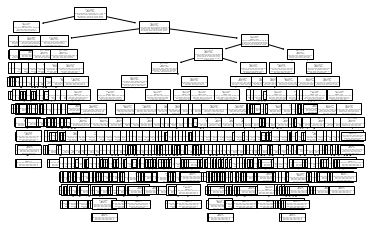

<Figure size 1440x1440 with 0 Axes>

In [12]:
as_num = lambda string : {_:i for i,_ in enumerate(us_cities[string].unique())}

# State Prediction Accuracy (0.5 test split):
# timezone -> [0.303,0.309]
# ranking -> [0.08,0.08]
# [lat,long] -> [1.0,0.97]
# [timezone,ranking] -> [0.305,0.311]
# ['lat','timezone','density']  -> [1.0,0.587]


features = ['lat','long'] 
X = us_cities[features]
# X['timezone'] = X['timezone'].map(as_num('timezone'))
# X['county'] = X['county'].map(as_num('county'))
X = X.values

y = us_cities['state'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.5)

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

print("Predicting a City's State:")
y_pred_t = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Decision Tree: State with Latitude and Longitude')
_ = tree.plot_tree(decisionTree)
_ = plt.figure(figsize=(20,20))
plt.show()

**INTERPRETATION:** It makes plenty of intuitive sense for latitude and longitude to be the best predictors of a given city's state. Interestingly, however, the *timezone* variable can act as a quasi-longitude coordinate, just more discretized. So, using the latitude and timezone of a city can yield about 99.4% and 55.3% accuracy for the training and test data respectively.

In [13]:
features = ['county','timezone'] 
X = us_cities[features]
X['timezone'] = X['timezone'].map(as_num('timezone'))
X['county'] = X['county'].map(as_num('county'))
X = X.values

y = us_cities['state'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.5)

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

print("Predicting a City's State with Timezone and County:")
y_pred_t = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Predicting a City's State with Timezone and County:
Accuracy on training data=  0.8463391641353305
Accuracy on test data=  0.7791160452450775


C:\Users\arbur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\arbur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Timezone and county, being geographic/spacial variables, also do relatively well to predict a city's state. Other combinations of variables, however don't seem to compete with the two models shown. **Let's double check this with California.** Perhaps a subset will have more options than using spatial variables.

Predicting a City's State with Timezone and County:
Accuracy on training data=  1.0
Accuracy on test data=  0.8612903225806452 

Decision Tree: Counties with Latitude and Longitude


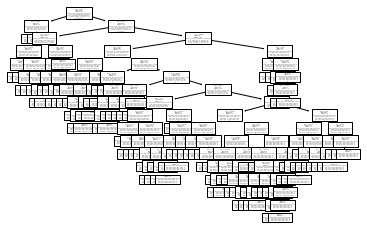

<Figure size 1440x1440 with 0 Axes>

Predicting a City's State with Population, 'incorporated' and Latitude:
Accuracy on training data=  1.0
Accuracy on test data=  0.38225806451612904


In [14]:
as_num = lambda string : {_:i for i,_ in enumerate(CA[string].unique())}

features = ['lat','long'] 
X = CA[features]
# X['county'] = X['county'].map(as_num('county'))
X = X.values

y = CA['county'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.5)

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

print("Predicting a City's State with Timezone and County:")
y_pred_t = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred),'\n')

print('Decision Tree: Counties with Latitude and Longitude')
_ = tree.plot_tree(decisionTree)
_ = plt.figure(figsize=(20,20))
plt.show()


features = ['population','incorporated','lat'] 
X = CA[features]
# X['county'] = X['county'].map(as_num('county'))
X = X.values

y = CA['county'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.5)

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

print("Predicting a City's State with Population, 'incorporated' and Latitude:")
y_pred_t = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

**INTERPRETATION:** Here, we see a similar effectivity for classifying a California city's county, but there is a noticeable dip in accuracy. Perhaps there is a higher likelihood for overlap in coordinates. We also see that all the other variables produce ~0% accuracies on their training sets without some spatial coordinate.

# Image Processing

In [15]:
#TODO - Process the RGB hists and intensities with a function, going through 

img_list = os.listdir('images/')[1:]
for img_name in img_list:
    img = Image.open('images/'+img_name)
    
#img_list

# Exploratory Analysis on Secondary Data Set (Capitals)

Our Secondary Data set of US Capitals differs only slightly from our orginal data set in how it is setup. The capitals data set has the orginal columns "military", "incorporated", because these values were either all false or all true, leading to no variance from captial to capital. Also removed is the state name, as the state id was deemed informative enough. Lastly, the capitals data set includes 3 new colums of data that capture the % change in average Red, Green, and Blue values per year. These values came from our image processing outlined previously.

In [17]:
us_capitals = pd.read_csv("just_capitals.csv")
us_capitals = us_capitals.drop(columns='Unnamed: 0')
print('Description of U.S. Capitals Dataset:')
us_capitals.describe()

Description of U.S. Capitals Dataset:


,lat,long,population,density,ranking,zips,dR_year,dG_year,dB_year
count,51.000000,51.000000,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,39.409669,-93.135641,8.861300e+05,1294.019608,1.745098,33.117647,0.007183,0.006346,0.004890
std,5.674883,18.612157,1.336798e+06,1144.495548,0.483452,42.916965,0.010532,0.008589,0.005382
min,21.329400,-157.846000,7.372000e+03,4.000000,1.000000,1.000000,0.000069,0.000117,0.000041
25%,36.002000,-102.779700,1.142755e+05,596.000000,1.000000,8.500000,0.001825,0.001829,0.001542
50%,39.771000,-89.653800,3.253500e+05,938.000000,2.000000,24.000000,0.004563,0.004056,0.003010
75%,42.690300,-78.059550,1.057268e+06,1533.000000,2.000000,39.500000,0.006542,0.006053,0.006120
max,58.454600,-69.731900,5.449398e+06,5532.000000,3.000000,292.000000,0.059436,0.046600,0.025569


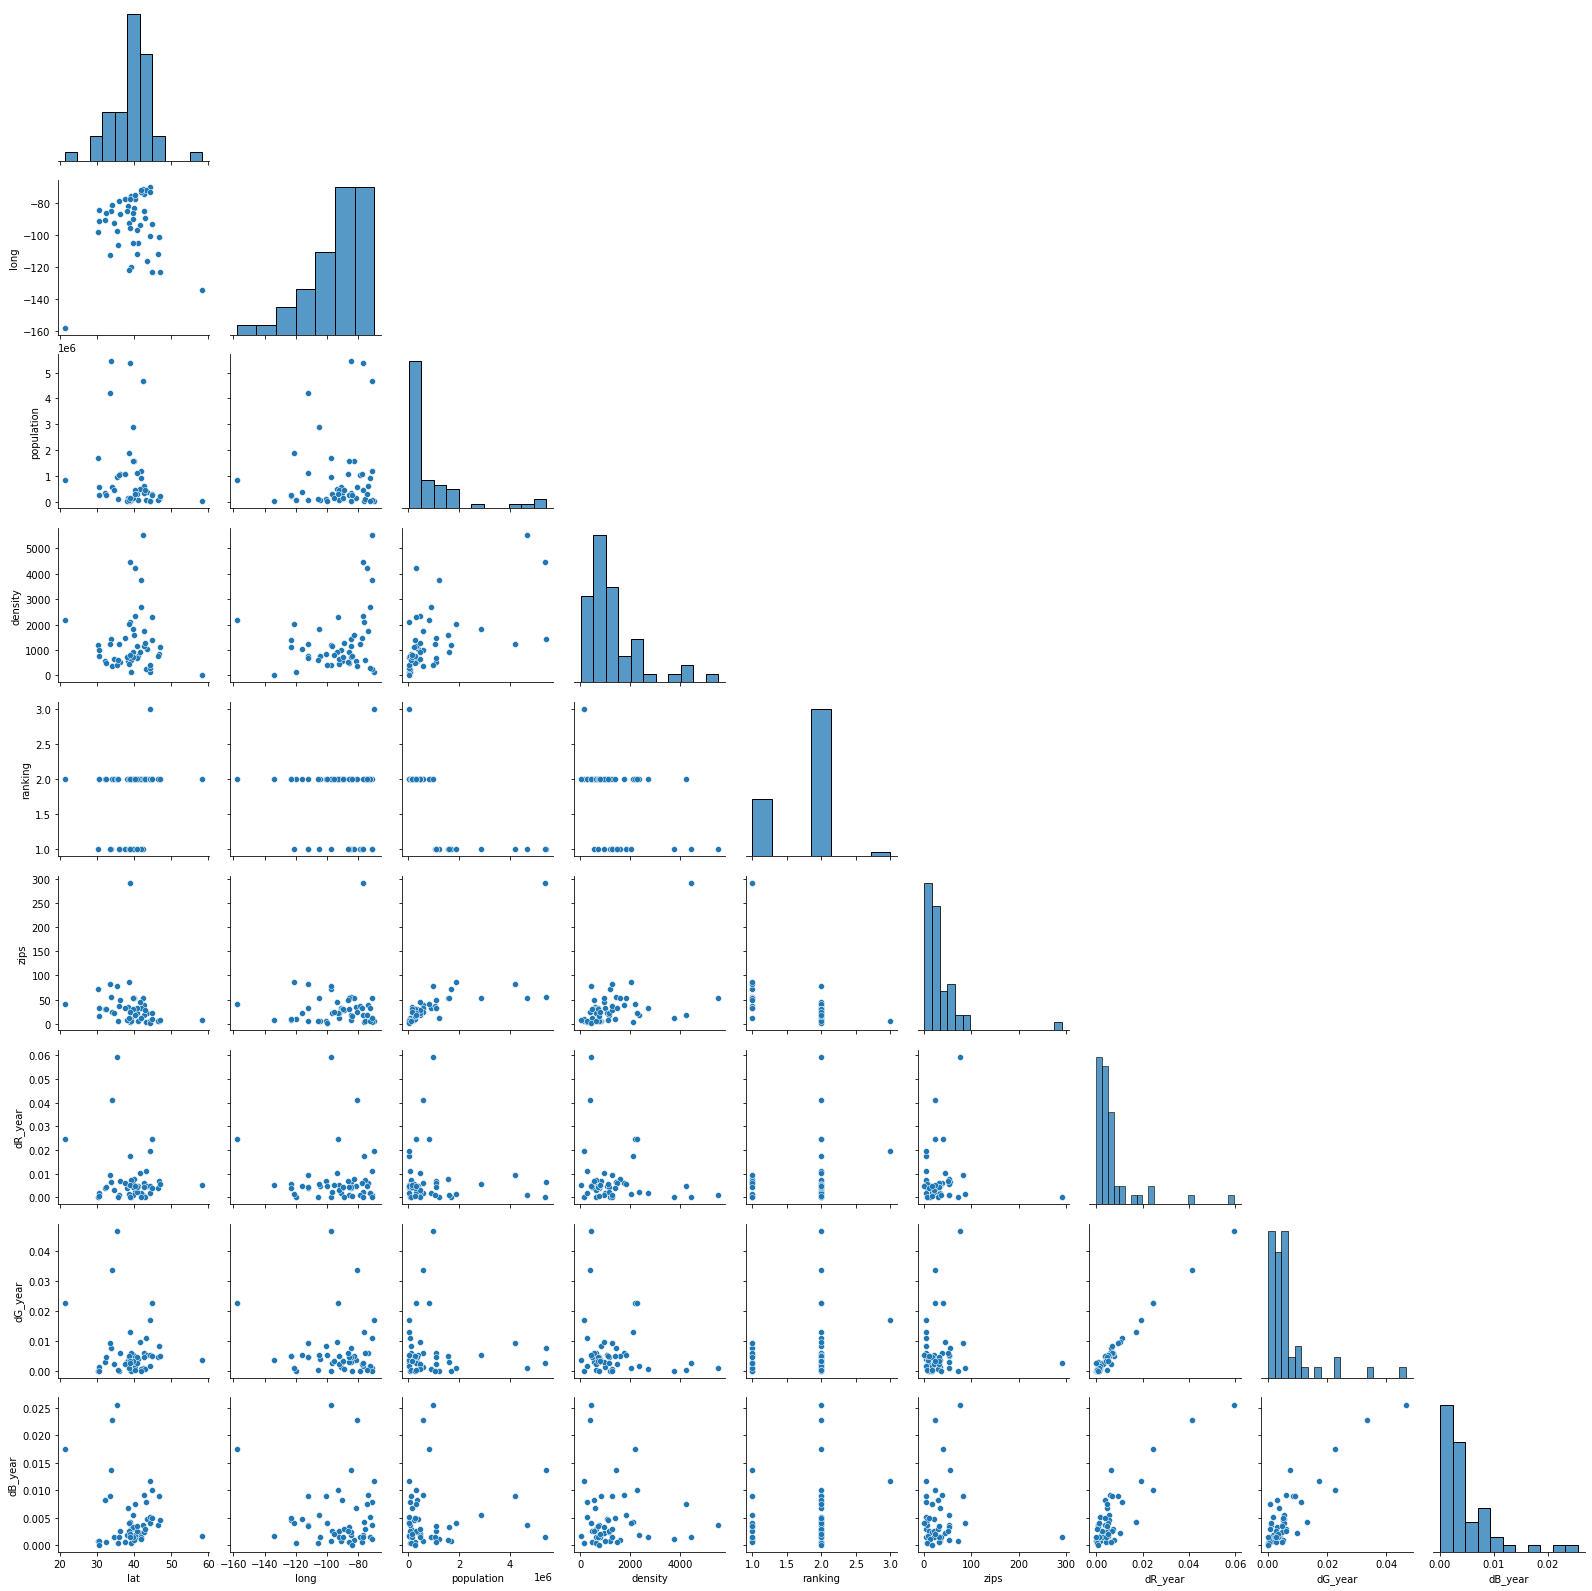

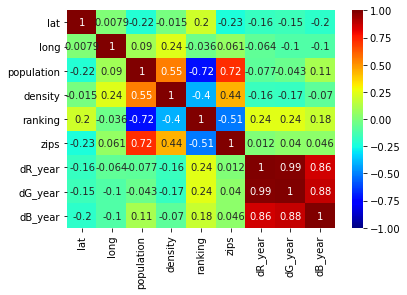

In [18]:
sn.pairplot(us_capitals, corner=True)

# Calculate Correlation Matrix

capital_correlation = us_capitals.corr()
plt.figure()
sn.heatmap(capital_correlation, vmin=-1, vmax=1, cmap='jet', annot=True)
plt.show()

**INTERPRETATION:**
Visably the *ranking* variable appears to be most correlated to a city's density, population, and number of zip codes. However, since our project included image analysis we wanted to include the data that was pulled from the queryed images. Initially we wondered if the percent change in RGB/year would be an accurate predictor of population, and or density of population in capital cities. However, from the data visualization above the variable RGB/year values looked to be correlated with population and density in regions. For instance it looks like various RGB/year changes are correlated with density from 0-1000, and again from 1000-2000, and finally from 2000+. Similar behavior is seen when looking at RGB/year when compared with population. Therefore, we have decided to create 2 new variables to our data set, both categorical, that explain population and density on a scale of 1-3, similar to how the *ranking* variable is set up. Later, we will explore PCA Analysis on the entire data set and determine the effectiveness of PCA on predicting the variance in *Population* and *Density*. Lastly, we will explore the effect of RGB/year on the 3 categorical variables (*population_rank*, *density_rank*, and *ranking*).

# Creation of New Categorical Variables

**Population Rank:**
1. : 0 - 1 million
2. : 1 - 2.5 million
3. : 2.5+ million

**Density Rank:**
1. : 0 - 1000
2. : 1000 - 2000
3. : 2000+

In [19]:
criteria1 = [us_capitals['density'].between(0, 1000), us_capitals['density'].between(1000, 2000), us_capitals['density'].between(2000, 6000)]
criteria2 = [us_capitals['population'].between(0, 1e6), us_capitals['population'].between(1e6, 2.5e6), us_capitals['population'].between(2.5e6, 7e6)]
categories = [1, 2, 3]

us_capitals['density_rank'] = np.select(criteria1, categories, 0) 
us_capitals['population_rank'] = np.select(criteria2, categories, 0)

# PCA
PCA will be used to decompose the RGB dimensions into principle component(s) to determine quality of clustering, for both categorical population, and density. Before, attempting PCA we dropped Washington DC as it was a major outlier, and often not referred to as a capital of a state.

In [20]:
us_capitals = us_capitals.drop(50)

**PCA for Population**

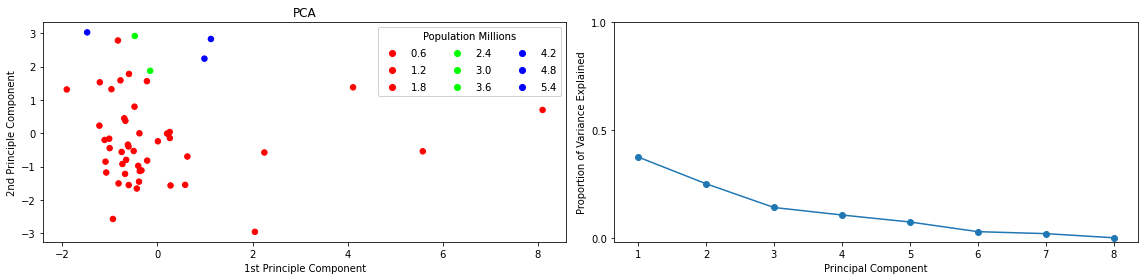

[0.37587119 0.25166546 0.14147814 0.10656402 0.07409485 0.0292817
 0.02006706 0.00097759]


In [21]:
pca_model = PCA()
X = scale(us_capitals.drop(['population', 'state_id', 'city','timezone','county','density_rank','population_rank'],axis=1).values)
X_PCA = pca_model.fit_transform(X)
y = us_capitals['population'].values

cluster_model = AgglomerativeClustering(linkage='ward', n_clusters=6)
y_pred = cluster_model.fit_predict(X)

var_ratio = pca_model.explained_variance_ratio_
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 2, 1)

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y, cmap=cmap_bold,s=30)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", ncol= 3, title="Population Millions")

ax.add_artist(legend1)

ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_title('PCA')

ax = fig.add_subplot(1, 2, 2)

ax.plot([1,2,3,4,5,6,7,8], var_ratio, '-o')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_xlabel('Principal Component')
ax.set_yticks([0,0.5,1])
ax.set_xticks([1,2,3,4,5,6,7,8])

plt.tight_layout()  

plt.show()
print(var_ratio)



From the plot above on the right we see that only 37.6% of the variance in the data is contained in the first principle component. Therefore, we will only use the first Principle component.

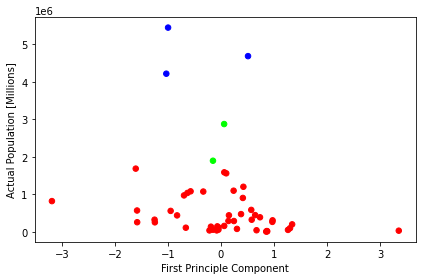

In [22]:
fig = plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:, 0], y, c=y, cmap=cmap_bold,s=30)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Actual Population [Millions]')

plt.tight_layout()  
plt.show()

**PCA for Density**

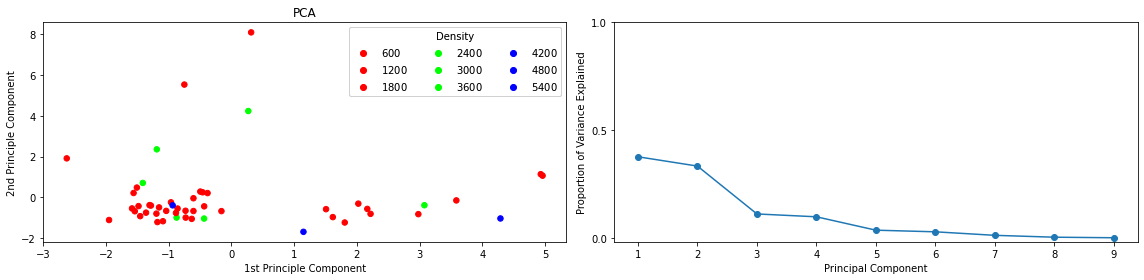

[0.37655604 0.33337317 0.1112576  0.09807626 0.03598049 0.02839417
 0.01207493 0.00342483 0.0008625 ]


In [23]:
X = scale(us_capitals.drop(['state_id', 'city','timezone','county','density','density_rank'],axis=1).values)
X_PCA = pca_model.fit_transform(X)
y = us_capitals['density'].values

cluster_model = AgglomerativeClustering(linkage='ward', n_clusters=6)
y_pred = cluster_model.fit_predict(X)

var_ratio = pca_model.explained_variance_ratio_
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 2, 1)

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y, cmap=cmap_bold,s=30)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", ncol= 3, title="Density")

ax.add_artist(legend1)

ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_title('PCA')

ax = fig.add_subplot(1, 2, 2)

ax.plot([1,2,3,4,5,6,7,8,9], var_ratio, '-o')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_xlabel('Principal Component')
ax.set_yticks([0,0.5,1])
ax.set_xticks([1,2,3,4,5,6,7,8,9])

plt.tight_layout()  

plt.show()
print(var_ratio)


From the plot above on the right we see that 37.6% and 33.3% of the variance in the data is contained in the first two principle components. Therefore, we will only use the first and second principle components.

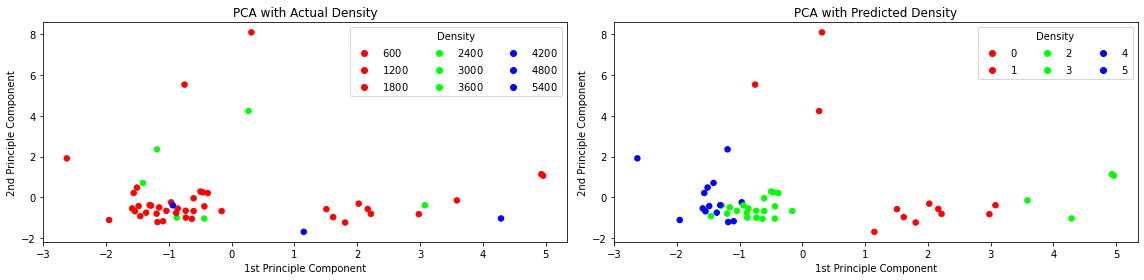

[0.37655604 0.33337317 0.1112576  0.09807626 0.03598049 0.02839417
 0.01207493 0.00342483 0.0008625 ]


In [24]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 2, 1)

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y, cmap=cmap_bold,s=30)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", ncol= 3, title="Density")
ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_title('PCA with Actual Density')

ax = fig.add_subplot(1, 2, 2)

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred, cmap=cmap_bold,s=30)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", ncol= 3, title="Density")

ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_title('PCA with Predicted Density')

plt.tight_layout()  

plt.show()
print(var_ratio)


**INTERPRETATION:**
From PCA of both Density and Population the predictions were both poor. This is visually seen in the plot above as the PCA qualifier was only able to classify a handful of data points correctly. We are unclear why PCA render such poor results. If there were more time we would plan to dive back in and see what variables would do the best job at prediction Population and or Density of capital cities. 

# Analysis of New Categorical Variables

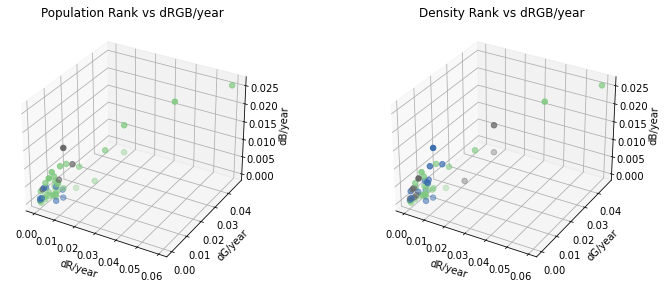

In [25]:
variables_of_interest = ['dR_year', 'dG_year', 'dB_year']

X = us_capitals[variables_of_interest].values
y = us_capitals['population_rank'].values

fig = plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(X[:, 0], X[:, 1],zs= X[:, 2], c=y, cmap='Accent',s=30)

ax.set_xlabel('dR/year')
ax.set_ylabel('dG/year')
ax.set_zlabel('dB/year')
ax.set_title('Population Rank vs dRGB/year')

ax = fig.add_subplot(1, 2, 2, projection='3d')
y = us_capitals['density_rank'].values

ax.scatter(X[:, 0], X[:, 1],zs= X[:, 2], c=y, cmap='Accent',s=30)

ax.set_xlabel('dR/year')
ax.set_ylabel('dG/year')
ax.set_zlabel('dB/year')
ax.set_title('Density Rank vs dRGB/year')

plt.tight_layout()  
plt.show()


**2D View**

/Users/joe95/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/joe95/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

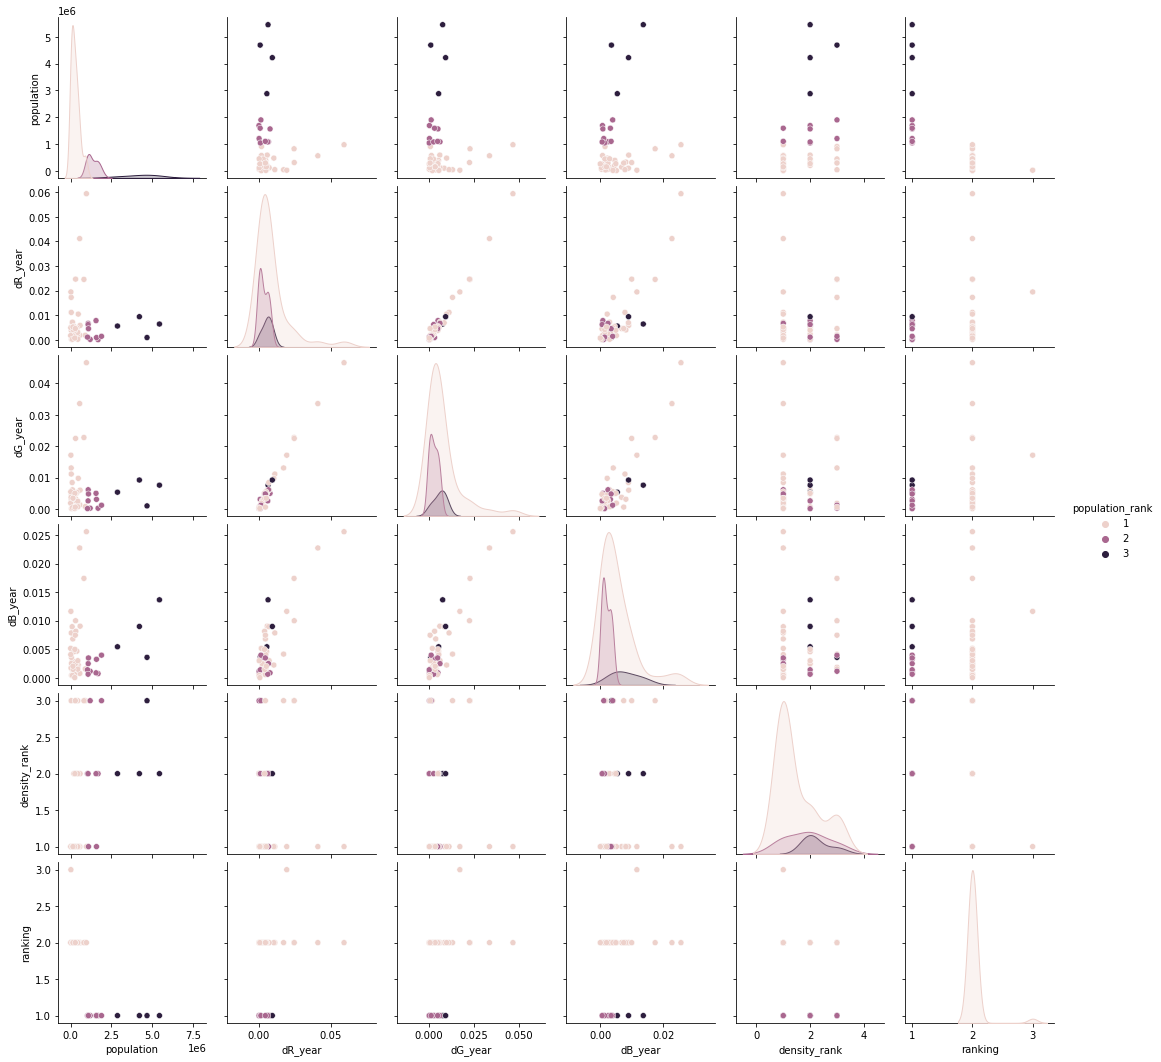

In [26]:
plt.figure()
variables_of_interest = ['population','dR_year', 'dG_year', 'dB_year','population_rank','density_rank', 'ranking']

sn.pairplot(us_capitals[variables_of_interest], hue='population_rank')
plt.show()

# Linear Regression - U.S. Capitals

In [39]:
population_cat_class = sm.ols(formula="population_rank ~ dR_year + dB_year + dG_year", data=us_capitals).fit()
population_cat_class.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        population_rank   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.311
Date:                Sun, 25 Apr 2021   Prob (F-statistic):              0.282
Time:                        19:59:09   Log-Likelihood:                -44.994
No. Observations:                  50   AIC:                             97.99
Df Residuals:                      46   BIC:                             105.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3233      0.121     10.910      0.000       1.079       1.567
dR_year      -13.0076     59.491     -0.219      0.828    -132.758     106.743
dB_year       55.8154     34.822      1.603      0.116     -14.277     125.908
dG_year      -25.6625     78.392     -0.327      0.745    -183.457     132.132
==============================================================================
Omnibus:                       13.197   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.336
Skew:                           1.281   Prob(JB):                     0.000771
Kurtosis:                       3.560   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**INTERPRETATION:** From this Regression it is clear that population_rank, density_rank, and ranking are not linear functions of dRGB/year, with an R^2 value less than 0.1. The next approach will be to take a linear regression of just the population rank 1 with respect to dRGB/year. We came to the conclusion that more established capitals just as Phoenix, Indianapolis, and Austin would not visably change per year at least from a satellite's perspective.


In [64]:
small_cites = us_capitals[us_capitals['population'] <= 1e6]

population_cat_class = sm.ols(formula="population ~ dR_year * dG_year * dB_year", data=small_cities).fit()
population_cat_class.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     2.893
Date:                Sun, 25 Apr 2021   Prob (F-statistic):             0.0202
Time:                        20:12:23   Log-Likelihood:                -502.78
No. Observations:                  37   AIC:                             1022.
Df Residuals:                      29   BIC:                             1034.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                3.421e+05    9.3e+04      3.677      0.001    1.52e+05    5.32e+05
dR_year                  6.455e+07   6.69e+07      0.965      0.343   -7.23e+07    2.01e+08
dG_year                 -1.134e+08   7.08e+07     -1.602      0.120   -2.58e+08    3.13e+07
dR_year:dG_year          8.783e+08   1.74e+09      0.506      0.617   -2.67e+09    4.43e+09
dB_year                  4.434e+06   2.08e+07      0.213      0.833   -3.82e+07     4.7e+07
dR_year:dB_year         -1.374e+10   8.85e+09     -1.553      0.131   -3.18e+10    4.36e+09
dG_year:dB_year          1.646e+10   9.36e+09      1.758      0.089   -2.69e+09    3.56e+10
dR_year:dG_year:dB_year  1.157e+10   6.31e+10      0.184      0.856   -1.17e+11    1.41e+11
==============================================================================
Omnibus:                        4.449   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                3.444
Skew:                           0.739   Prob(JB):                        0.179
Kurtosis:                       3.220   Cond. No.                     1.77e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.18e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**INTERPRETATION:** From the above linear regression we were able to obtain an R^2 value of 0.411 for a multi-dimensional linear regression of Small Capitals (i.e. population < 1 million) Population as a function of dRGB/year. Although, the R^2 value is poor, it was interesting to be able to see a positive trend in the data for one of our initial assumptions. With more time we would dive deeper into this relationship between population of small cities and the change in RGB/year to see if a different relationship would emerge that better captures the variance in the data.

# Conclusion

During the analyses for our *us_cities* dataset, we found that a very large portion of the set is in fact made up of towns, boroughs, and distinct parts of greater cities. Our source for the dataset states that entries can refer to 'named locations' that have a populous. The variables that best correlate with a city's population are its population the number of ZIP codes it has, its population density, its 'ranking', and whether or not the city is a state capital. The 'ranking' variable appears to be most related to the population and density of a city, but more factors that affect it fall outside of our dataset such as the city's age, historical significance, cultural significance, and the like. 

To predict a city's county and state, the variables that yield the most accurate classifier models are its latitude and longitude coordinates. For a model to achieve a test accuracy above 40%, it had to consider some spatial variable. This signifies that generally for all cities, the non-spatial values of our variables are well distributed throughout the country.

Regarding satellite image analyses for *us_capitals*, it appears with this particular approach and dataset our findings would not generalize well for the greater *us_cities* dataset. It's likely that different API's that flag cloudy images, offer closer time steps, and better normalize the bounds of images could improve this form of analysis, along with a dataset that contains multiple 